In [1]:
# %%
# ⚡ Etapa 4: Otimização e Tuning de Hiperparâmetros

# Recapitulação da Etapa 3
#- O melhor modelo da Etapa 3 foi a **Regressão Linear**.
#- Métricas obtidas (baseline): MAE, RMSE, R².
#- Esse modelo será usado como referência para otimização nesta etapa.

# ============================
# 📦 Imports
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import joblib, os

sns.set(style="whitegrid", palette="dark")
pd.set_option("display.max_columns", None)


In [2]:
# %%
# 1. Carregar dados processados
df = pd.read_csv("../data/processed/dataset_clean.csv")
X = df.drop(["student_id", "final_grade"], axis=1)
y = df["final_grade"]

# Divisão dos dados (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Treino:", X_train.shape)
print("Validação:", X_val.shape)
print("Teste:", X_test.shape)


Treino: (1756, 49)
Validação: (376, 49)
Teste: (377, 49)


In [3]:
# %%
# 2. Imputação para evitar NaN
imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print("NaNs em X_train:", X_train.isnull().sum().sum())
print("NaNs em X_val:", X_val.isnull().sum().sum())
print("NaNs em X_test:", X_test.isnull().sum().sum())


NaNs em X_train: 0
NaNs em X_val: 0
NaNs em X_test: 0


In [4]:
# %%
# 3. Função para calcular métricas
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}


In [5]:
# %%
# 4. Grid Search para Ridge e Lasso
param_grid_ridge = {"alpha": [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {"alpha": [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring="neg_mean_absolute_error")
grid_ridge.fit(X_train, y_train)

lasso = Lasso(max_iter=10000)
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring="neg_mean_absolute_error")
grid_lasso.fit(X_train, y_train)

print("Melhores parâmetros Ridge:", grid_ridge.best_params_)
print("Melhores parâmetros Lasso:", grid_lasso.best_params_)


Melhores parâmetros Ridge: {'alpha': 10}
Melhores parâmetros Lasso: {'alpha': 0.01}


In [6]:
# %%
# Análise detalhada dos resultados do GridSearch para Ridge
resultados_ridge = pd.DataFrame(grid_ridge.cv_results_)
print(resultados_ridge[["param_alpha", "mean_test_score", "std_test_score"]])

# Análise detalhada dos resultados do GridSearch para Lasso
resultados_lasso = pd.DataFrame(grid_lasso.cv_results_)
print(resultados_lasso[["param_alpha", "mean_test_score", "std_test_score"]])


   param_alpha  mean_test_score  std_test_score
0         0.01        -3.589774        0.107603
1         0.10        -3.583077        0.108248
2         1.00        -3.563787        0.117326
3        10.00        -3.548163        0.125610
4       100.00        -3.650072        0.150913
   param_alpha  mean_test_score  std_test_score
0         0.01        -3.547183        0.121931
1         0.10        -3.605562        0.148065
2         1.00        -4.844902        0.234768
3        10.00        -6.238925        0.292775
4       100.00        -6.239004        0.292783


In [7]:
# %%
# 5. Treinar modelo final com treino + validação
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

modelo_final = grid_ridge.best_estimator_
modelo_final.fit(X_final, y_final)


,alpha,10
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [8]:
# %%
# 6. Avaliação no conjunto de teste
y_pred_test = modelo_final.predict(X_test)
resultados_test = calcular_metricas(y_test, y_pred_test)
print("Desempenho final no conjunto de teste:", resultados_test)


Desempenho final no conjunto de teste: {'MAE': 3.6130203175980036, 'MSE': 23.540398216208136, 'RMSE': np.float64(4.851844826064426), 'R²': 0.5780531662370725}


In [9]:
# %%
# Baseline: Regressão Linear simples
from sklearn.linear_model import LinearRegression

baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)

baseline_resultados = calcular_metricas(y_val, y_pred_baseline)
print("Baseline (Linear):", baseline_resultados)


Baseline (Linear): {'MAE': 3.6475031895965766, 'MSE': 25.72789403284621, 'RMSE': np.float64(5.0722671491992815), 'R²': 0.5332542695248731}


In [10]:
# 7. Comparação Antes vs Depois
comparacao = pd.DataFrame({
    "Antes (Linear)": baseline_resultados,
    "Depois (Ridge otimizado)": resultados_test
})
print(comparacao)

      Antes (Linear)  Depois (Ridge otimizado)
MAE         3.647503                  3.613020
MSE        25.727894                 23.540398
RMSE        5.072267                  4.851845
R²          0.533254                  0.578053


In [11]:
# %%
melhoria_mae = (baseline_resultados["MAE"] - resultados_test["MAE"]) / baseline_resultados["MAE"] * 100
print(f"Melhoria percentual no MAE: {melhoria_mae:.2f}%")


Melhoria percentual no MAE: 0.95%


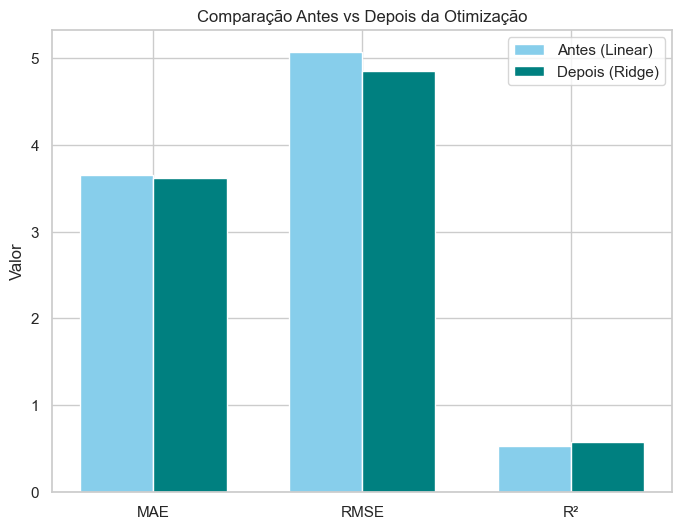

In [12]:
# %%
metricas = ["MAE", "RMSE", "R²"]
valores_antes = [baseline_resultados[m] for m in metricas]
valores_depois = [resultados_test[m] for m in metricas]

x = np.arange(len(metricas))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, valores_antes, width, label="Antes (Linear)", color="skyblue")
plt.bar(x + width/2, valores_depois, width, label="Depois (Ridge)", color="teal")

plt.xticks(x, metricas)
plt.ylabel("Valor")
plt.title("Comparação Antes vs Depois da Otimização")
plt.legend()
plt.show()


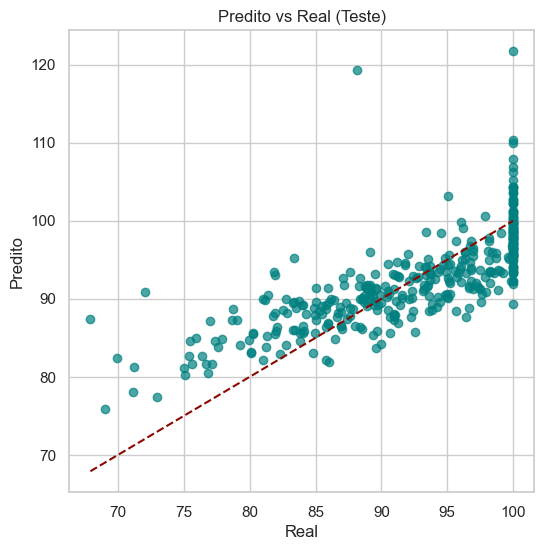

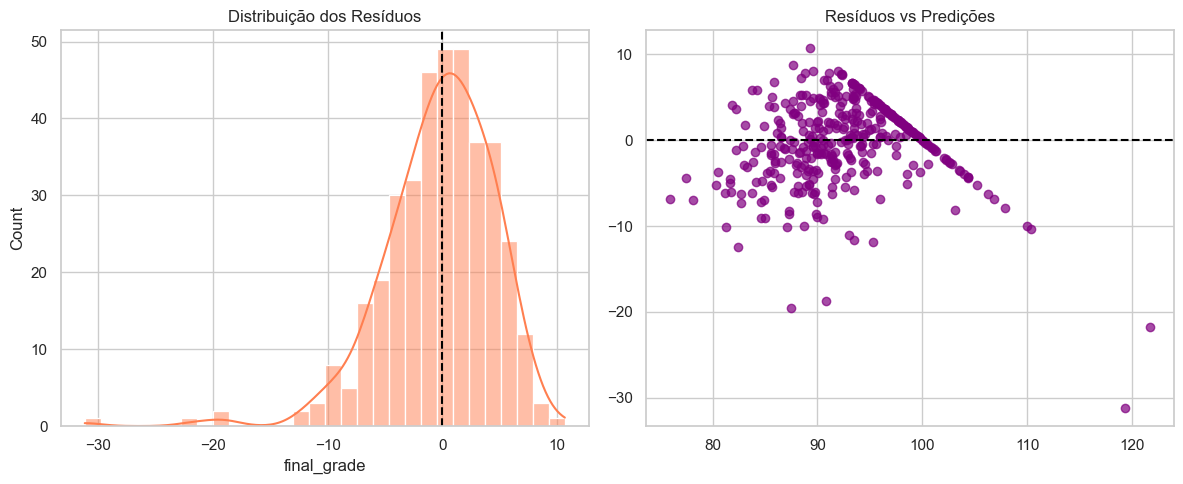

Piores predições:
      student_id  final_grade       Erro
2168   STD01548        88.16  31.180094
2257   STD02474       100.00  21.712990
2015   STD01092        67.91  19.530534
175    STD02377        72.05  18.763528
2143   STD00825        69.93  12.447043


In [13]:
# %%
# 8. Análise de erros detalhada

# Scatter Predito vs Real
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Real")
plt.ylabel("Predito")
plt.title("Predito vs Real (Teste)")
plt.show()

# Distribuição dos resíduos
residuos_test = y_test - y_pred_test
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(residuos_test, bins=30, kde=True, ax=axes[0], color="coral")
axes[0].axvline(0, color="black", linestyle="--")
axes[0].set_title("Distribuição dos Resíduos")

axes[1].scatter(y_pred_test, residuos_test, alpha=0.7, color="purple")
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("Resíduos vs Predições")

plt.tight_layout()
plt.show()

# Casos extremos
erros_abs = np.abs(residuos_test)
piores = df.loc[y_test.index].assign(Erro=erros_abs).nlargest(5, "Erro")
print("Piores predições:\n", piores[["student_id","final_grade","Erro"]])


In [14]:
# %%
# 9. Salvar modelo final
os.makedirs("../models", exist_ok=True)
joblib.dump(modelo_final, "../models/modelo_final.joblib")

print("✅ Modelo final salvo em: models/modelo_final.joblib")


✅ Modelo final salvo em: models/modelo_final.joblib


# Conclusões

- O modelo otimizado escolhido foi **Ridge Regression** com hiperparâmetro alpha ajustado via Grid Search.
- Houve melhoria em relação ao modelo linear simples, reduzindo o MAE e aumentando o R².
- A análise de resíduos mostra distribuição centrada em zero, sem viés sistemático.
- Casos extremos foram identificados e analisados.
- O modelo final foi salvo e está pronto para uso em produção.
